In [16]:
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import numpy as np
import os
from pathlib import Path
import json
import collections
from src.visualize import filter_path_1, filter_path_2, get_scores, get_scores_json, plot_scores, calculate_average_ranking, calculate_average_score

In [17]:
DATASET_GROUP = "MMLU"
base_path = f"/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/results/{DATASET_GROUP}"
results_one_shot_path = os.path.join(base_path, "results.json")
results_few_shot_path = os.path.join(base_path, "results_few-shot.json")

with open(results_one_shot_path) as f:
    results_one_shot = json.load(f)

with open(results_few_shot_path) as f:
    results_few_shot = json.load(f)

In [32]:
DATASET_GROUP = "MMLU"
with open(base_path + "/results.json") as f:
    results_mmlu = json.load(f)
DATASET_GROUP = "BIGBENCH"
base_path = f"/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/results/{DATASET_GROUP}"
with open(base_path + "/results.json") as f:
    results_bigbench = json.load(f)

if DATASET_GROUP == "BIGBENCH":
    metric = 'multiple_choice_grade'
    metric_std = 'multiple_choice_grade_stderr'
if DATASET_GROUP == "MMLU":
    metric = 'acc'
    metric_std = 'acc_stderr'



In [33]:
results_bigbench.items()

dict_items([('bigbench_causal_judgement', {'c4 NLI': {'1.4B': {'multiple_choice_grade': 0.5368421052631579, 'multiple_choice_grade_stderr': 0.036270781985214155}, '160M': {'multiple_choice_grade': 0.5210526315789473, 'multiple_choice_grade_stderr': 0.03633739504773335}}, 'c4': {'1.4B': {'multiple_choice_grade': 0.4842105263157895, 'multiple_choice_grade_stderr': 0.036351509398643456}, '160M': {'multiple_choice_grade': 0.4842105263157895, 'multiple_choice_grade_stderr': 0.036351509398643456}}, 'c4 Summarization': {'160M': {'multiple_choice_grade': 0.531578947368421, 'multiple_choice_grade_stderr': 0.036297038088316115}, '1.4B': {'multiple_choice_grade': 0.5263157894736842, 'multiple_choice_grade_stderr': 0.03631923996538703}}, 'c4 QA': {'160M': {'multiple_choice_grade': 0.47368421052631576, 'multiple_choice_grade_stderr': 0.03631923996538703}, '1.4B': {'multiple_choice_grade': 0.5631578947368421, 'multiple_choice_grade_stderr': 0.036078330444807245}}, 'c4 Commonsense': {'160M': {'multip

In [37]:
merged_results['bigbench_causal_judgement']

{'c4 NLI': {'1.4B': {'multiple_choice_grade': 0.5368421052631579,
   'multiple_choice_grade_stderr': 0.036270781985214155},
  '160M': {'multiple_choice_grade': 0.5210526315789473,
   'multiple_choice_grade_stderr': 0.03633739504773335}},
 'c4': {'1.4B': {'multiple_choice_grade': 0.4842105263157895,
   'multiple_choice_grade_stderr': 0.036351509398643456},
  '160M': {'multiple_choice_grade': 0.4842105263157895,
   'multiple_choice_grade_stderr': 0.036351509398643456}},
 'c4 Summarization': {'160M': {'multiple_choice_grade': 0.531578947368421,
   'multiple_choice_grade_stderr': 0.036297038088316115},
  '1.4B': {'multiple_choice_grade': 0.5263157894736842,
   'multiple_choice_grade_stderr': 0.03631923996538703}},
 'c4 QA': {'160M': {'multiple_choice_grade': 0.47368421052631576,
   'multiple_choice_grade_stderr': 0.03631923996538703},
  '1.4B': {'multiple_choice_grade': 0.5631578947368421,
   'multiple_choice_grade_stderr': 0.036078330444807245}},
 'c4 Commonsense': {'160M': {'multiple_cho

In [39]:
# Initialize a new dictionary to store the merged results
merged_results = {}

# Iterate over the keys (datasets) and values (results) in results_mmlu
for dataset, results in results_mmlu.items():
    # If the dataset also exists in results_bigbench, merge the results
    if dataset in results_bigbench:
        merged_results[dataset] = {**results, **results_bigbench[dataset]}
    # Otherwise, just copy the results from results_mmlu
    else:
        merged_results[dataset] = results

# Iterate over the keys (datasets) and values (results) in results_bigbench
for dataset, results in results_bigbench.items():
    # If the dataset does not exist in merged_results (and therefore also in results_mmlu), copy the results from results_bigbench
    if dataset not in merged_results:
        merged_results[dataset] = results

# Change the metric keys to 'acc' and 'acc_stderr'
for dataset in merged_results:
    for model in merged_results[dataset]:
        for param_size in merged_results[dataset][model]:
            if dataset in results_bigbench.keys():
                merged_results[dataset][model][param_size]['acc'] = merged_results[dataset][model][param_size].pop('multiple_choice_grade')
                merged_results[dataset][model][param_size]['acc_stderr'] = merged_results[dataset][model][param_size].pop('multiple_choice_grade_stderr')
            else:
                merged_results[dataset][model][param_size]['acc'] = merged_results[dataset][model][param_size].pop('acc')
                merged_results[dataset][model][param_size]['acc_stderr'] = merged_results[dataset][model][param_size].pop('acc_stderr')

In [44]:
MODEL_ORDER = ["c4 160M", "c4 1.4B", "c4 QA 160M", "c4 QA 1.4B", "c4 NLI 160M", "c4 NLI 1.4B", 
               "c4 Summarization 160M", "c4 Summarization 1.4B", "c4 Commonsense 160M", "c4 Commonsense 1.4B"]

DATASET_ORDER = ["c4", "c4 QA", "c4 NLI", "c4 Summarization", "c4 Commonsense"]

c4_only = ['c4']
c4_supervised = [model for model in DATASET_ORDER if model not in c4_only]
# c4_supervised = ['c4 Commonsense']

if DATASET_GROUP == "BIGBENCH":
    metric = 'multiple_choice_grade'
    metric_std = 'multiple_choice_grade_stderr'
if DATASET_GROUP == "MMLU":
    metric = 'acc'
    metric_std = 'acc_stderr'

def calculate_average(results_one_shot, DATASET_GROUP):
    metric = 'acc'
    metric_std = 'acc_stderr'
    results_average = collections.defaultdict(lambda: collections.defaultdict(list))

    for dataset in results_one_shot.keys():
        for training_dataset in results_one_shot[dataset].keys():
            for param_size in results_one_shot[dataset][training_dataset].keys():
                results_average[training_dataset][param_size].append(results_one_shot[dataset][training_dataset][param_size][metric])

    for training_dataset in results_average.keys():
        for param_size in results_average[training_dataset].keys():
            results_average[training_dataset][param_size] = np.mean(results_average[training_dataset][param_size])
    
    return results_average

results_average = calculate_average(results_one_shot, DATASET_GROUP)
results_average_merged = calculate_average(merged_results, DATASET_GROUP)

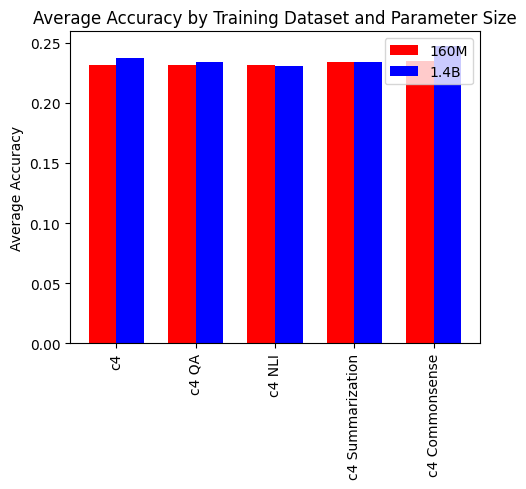

In [50]:
def plot_average_accuracy(results_average, DATASET_ORDER, param_sizes):
    # Define the colors for the two parameter sizes
    colors = {'160M': 'r', '1.4B': 'b'}

    # Get the keys (training datasets) and values (average accuracies) from results_average
    avg_accs = [[results_average[training_dataset][param_size] for param_size in param_sizes] for training_dataset in DATASET_ORDER]

    # Create a bar chart
    plt.figure(figsize=(5, 5))

    # Define the width of a bar
    bar_width = 0.35

    # Define the x locations for the groups
    x = np.arange(len(DATASET_ORDER))

    # Create the bars for each parameter size
    for i, param_size in enumerate(param_sizes):
        plt.bar(x + i*bar_width, [avg_accs[j][i] for j in range(len(avg_accs))], width=bar_width, color=colors[param_size])

    plt.xticks(x + bar_width / 2, DATASET_ORDER, rotation=90)
    plt.ylabel('Average Accuracy')
    plt.title('Average Accuracy by Training Dataset and Parameter Size')
    plt.legend(param_sizes)

    plt.tight_layout()
    plt.show()

plot_average_accuracy(results_average, DATASET_ORDER, ['160M', '1.4B'])

In [48]:
def group_and_average_results(results_average, c4_only):
    results_average_grouped = collections.defaultdict(lambda: collections.defaultdict(list))
    for training_dataset in results_average.keys():
        for param_size in results_average[training_dataset].keys():
            group = 'c4' if training_dataset in c4_only else 'c4 + (x,y)'
            results_average_grouped[group][param_size].append(results_average[training_dataset][param_size])

    # average
    for group in results_average_grouped.keys():
        for param_size in results_average_grouped[group].keys():
            results_average_grouped[group][param_size] = np.mean(results_average_grouped[group][param_size])
    
    return results_average_grouped

results_average_grouped = group_and_average_results(results_average, c4_only)
results_average_grouped_merged = group_and_average_results(results_average_merged, c4_only)

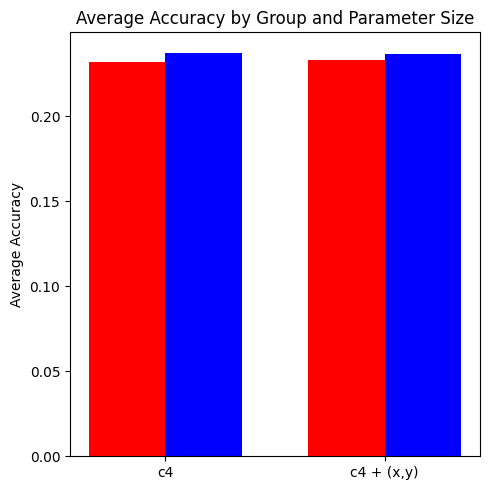

In [23]:
# Define the colors for the two parameter sizes
colors = {'160M': 'r', '1.4B': 'b'}

# Get the keys (groups) and values (average accuracies) from results_average_grouped
groups = ['c4', 'c4 + (x,y)']
param_sizes = ['160M', '1.4B']  # Change the order of the parameter sizes
avg_accs = [[results_average_grouped[group][param_size] for param_size in param_sizes] for group in groups]

# Create a bar chart
plt.figure(figsize=(5, 5))

# Define the width of a bar
bar_width = 0.35

# Define the x locations for the groups
x = np.arange(len(groups))

# Create the bars for each parameter size
for i, param_size in enumerate(param_sizes):
    plt.bar(x + i*bar_width, [avg_accs[j][i] for j in range(len(avg_accs))], width=bar_width, color=colors[param_size])

plt.xticks(x + bar_width / 2, groups)
plt.ylabel('Average Accuracy')
plt.title('Average Accuracy by Group and Parameter Size')
# plt.legend(param_sizes)

plt.tight_layout()
plt.show()

In [49]:
results_average

defaultdict(<function __main__.calculate_average.<locals>.<lambda>()>,
            {'c4 NLI': defaultdict(list,
                         {'1.4B': 0.23079744774485392,
                          '160M': 0.23138634763715182}),
             'c4': defaultdict(list,
                         {'1.4B': 0.23739738382491232,
                          '160M': 0.23189464020606868}),
             'c4 Summarization': defaultdict(list,
                         {'160M': 0.23390160308153252,
                          '1.4B': 0.23385088379200478}),
             'c4 QA': defaultdict(list,
                         {'160M': 0.23134131307182587,
                          '1.4B': 0.2341449969788315}),
             'c4 Commonsense': defaultdict(list,
                         {'160M': 0.2352615720728597,
                          '1.4B': 0.24724572024504543})})

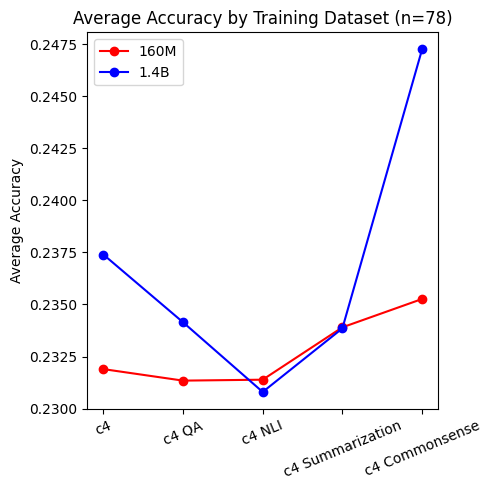

In [60]:
plot_accuracy_line(results_average, ['160M', '1.4B'], DATASET_ORDER)